In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import osmnx as ox
import networkx as nx
import plotly.express as px

## Access AFDC Data

In [2]:
alternative_fuels_data = pd.read_csv('datasets/alternative_fuels_data.csv')
alternative_fuels_data.head()

/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_17062/3979609620.py:1: DtypeWarning: Columns (14,28,29,33,34,43,46,50,51,52,53,54,55,56,60,62,63,66,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  alternative_fuels_data = pd.read_csv('datasets/alternative_fuels_data.csv')


,access_code,access_days_time,access_detail_code,cards_accepted,date_last_confirmed,expected_date,fuel_type_code,groups_with_access_code,id,maximum_vehicle_class,...,access_days_time_fr,intersection_directions_fr,bd_blends_fr,groups_with_access_code_fr,ev_pricing_fr,federal_agency.id,federal_agency.code,federal_agency.name,ev_network_ids.station,ev_network_ids.posts
0,private,NaN,NaN,NaN,2024-10-11,NaN,CNG,Private,17.0,MD,...,NaN,NaN,NaN,Privé,NaN,NaN,NaN,NaN,NaN,NaN
1,private,NaN,GOVERNMENT,NaN,2024-02-12,NaN,CNG,Private - Government only,45.0,LD,...,NaN,NaN,NaN,Privé - Réservé au gouvernement,NaN,NaN,NaN,NaN,NaN,NaN
2,private,NaN,NaN,NaN,2023-12-13,NaN,CNG,Private,64.0,HD,...,NaN,NaN,NaN,Privé,NaN,NaN,NaN,NaN,NaN,NaN
3,public,24 hours daily,CREDIT_CARD_ALWAYS,CREDIT M V Voyager,2024-04-14,NaN,CNG,Public - Credit card at all times,73.0,MD,...,NaN,NaN,NaN,Public - Carte de crédit en tout temps,NaN,NaN,NaN,NaN,NaN,NaN
4,public,24 hours daily; call 866-809-4869 for Clean En...,CREDIT_CARD_ALWAYS,A CleanEnergy Comdata D FuelMan M V Voyager Wr...,2024-11-06,NaN,CNG,Public - Credit card at all times,81.0,MD,...,NaN,NaN,NaN,Public - Carte de crédit en tout temps,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
fuel_code_count = alternative_fuels_data['fuel_type_code'].value_counts(dropna=False).to_dict()
fuel_code_count

{'ELEC': 82545,
 'E85': 4710,
 'LPG': 2834,
 'BD': 1791,
 'CNG': 1363,
 'RD': 655,
 'LNG': 114,
 'HY': 103,
 nan: 1}

In [4]:
np.array(alternative_fuels_data.columns)

array(['access_code', 'access_days_time', 'access_detail_code',
       'cards_accepted', 'date_last_confirmed', 'expected_date',
       'fuel_type_code', 'groups_with_access_code', 'id',
       'maximum_vehicle_class', 'open_date', 'owner_type_code',
       'restricted_access', 'status_code', 'funding_sources',
       'facility_type', 'station_name', 'station_phone', 'updated_at',
       'geocode_status', 'latitude', 'longitude', 'city', 'country',
       'intersection_directions', 'plus4', 'state', 'street_address',
       'zip', 'bd_blends', 'cng_dispenser_num', 'cng_fill_type_code',
       'cng_has_rng', 'cng_psi', 'cng_renewable_source',
       'cng_total_compression', 'cng_total_storage', 'cng_vehicle_class',
       'e85_blender_pump', 'e85_other_ethanol_blends',
       'ev_connector_types', 'ev_dc_fast_num', 'ev_level1_evse_num',
       'ev_level2_evse_num', 'ev_network', 'ev_network_web',
       'ev_other_evse', 'ev_pricing', 'ev_renewable_source',
       'ev_workplace_charging'

## Select Specific Columns From AFDC Data

In [5]:
enhanced_columns = [
    'station_name', 'city', 'state', 'zip', 'country', 'access_code',
    'latitude', 'longitude', 'fuel_type_code', 'status_code', 'open_date',
    'ev_connector_types', 'ev_dc_fast_num', 'ev_level1_evse_num',
    'ev_level2_evse_num', 'ev_network', 'ev_network_web', 'ev_other_evse',
    'ev_workplace_charging', 'ev_pricing'
]
alternative_fuels_data = alternative_fuels_data[enhanced_columns]

In [6]:
alternative_fuels_data.head()

,station_name,city,state,zip,country,access_code,latitude,longitude,fuel_type_code,status_code,open_date,ev_connector_types,ev_dc_fast_num,ev_level1_evse_num,ev_level2_evse_num,ev_network,ev_network_web,ev_other_evse,ev_workplace_charging,ev_pricing
0,Spire - Montgomery Operations Center,Montgomery,AL,36107,US,private,32.367916,-86.267021,CNG,E,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Metropolitan Atlanta Rapid Transit Authority,Atlanta,GA,30324,US,private,33.821911,-84.367461,CNG,E,1996-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United Parcel Service,Atlanta,GA,30336,US,private,33.760256,-84.543822,CNG,E,1997-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arkansas Oklahoma Gas Corp,Fort Smith,AR,72903,US,public,35.362213,-94.375338,CNG,E,1997-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Clean Energy - Logan International Airport,East Boston,MA,2128,US,public,42.374706,-71.026549,CNG,E,1996-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Specify AFDC Data From SDGE Territories and Electric Charging Stations Only

In [7]:
sdge_zip_csv = pd.read_csv('datasets/SDGE_zip.csv')
sdge_service_zip = sdge_zip_csv['ZipCode']
#sdge_service_zip = [str(zip) for zip in  sdge_service_zip]
charging_station_data = alternative_fuels_data[(alternative_fuels_data['zip'].isin(sdge_service_zip)) & (alternative_fuels_data['fuel_type_code'] == 'ELEC')]
# charging_station_data[charging_station_data['zip'] == 92122]
#data[data['station_name'].str.contains('UCSD', case = False, na = False)]

In [8]:
# There are 163 private EV charging stations
private_ev_stations = charging_station_data[charging_station_data['access_code'] == 'private']
private_ev_stations_count = len(private_ev_stations)
print(f'There are {private_ev_stations_count} private EV charging stations in SDGE territories.')

There are 139 private EV charging stations in SDGE territories.


## Creating a Distribution of EV Networks Bar Graph in SDGE Territories

Text(0.5, 1.0, 'Distribution of EV Networks')

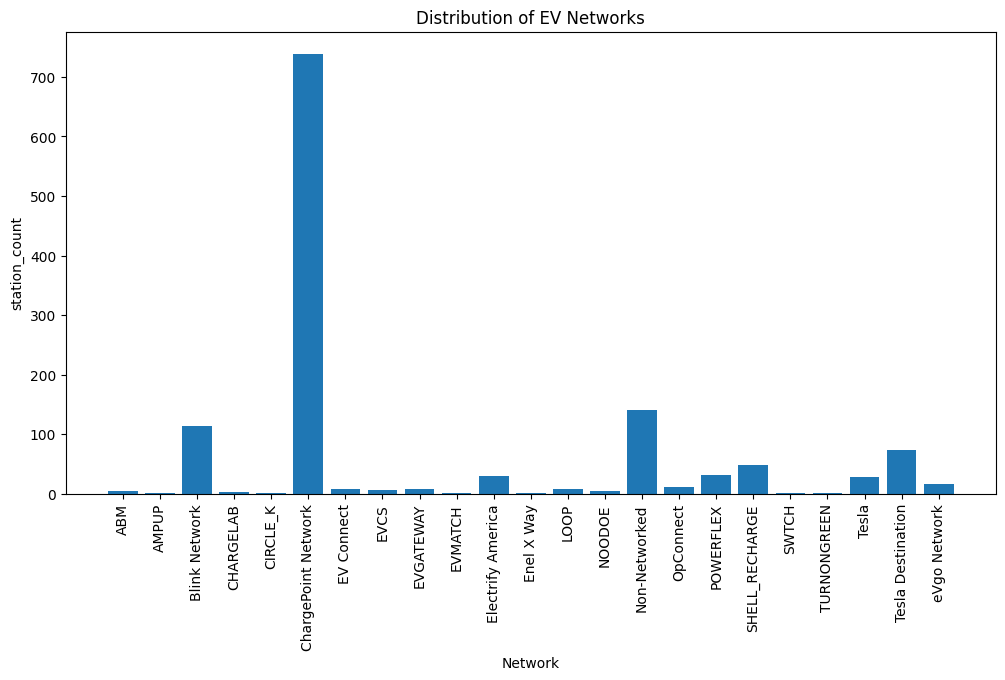

In [9]:
# Finding the distribution of ev_networks
ev_networks = charging_station_data.dropna(subset= 'ev_network')


ev_networks = ev_networks.groupby('ev_network').size().reset_index(name = 'station_count')
ev_networks.sort_values(by='station_count', ascending = False)

plt.figure(figsize = (12, 6))
plt.xticks(rotation = 90)
plt.bar(ev_networks['ev_network'], ev_networks['station_count'])
plt.xlabel('Network')
plt.ylabel('station_count')
plt.title('Distribution of EV Networks')


/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_17062/3345706687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_station_data['open_date'] = pd.to_datetime(charging_station_data['open_date'])
/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_17062/3345706687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_ev_stations['year'] = public_ev_stations['open_date'].dt.year


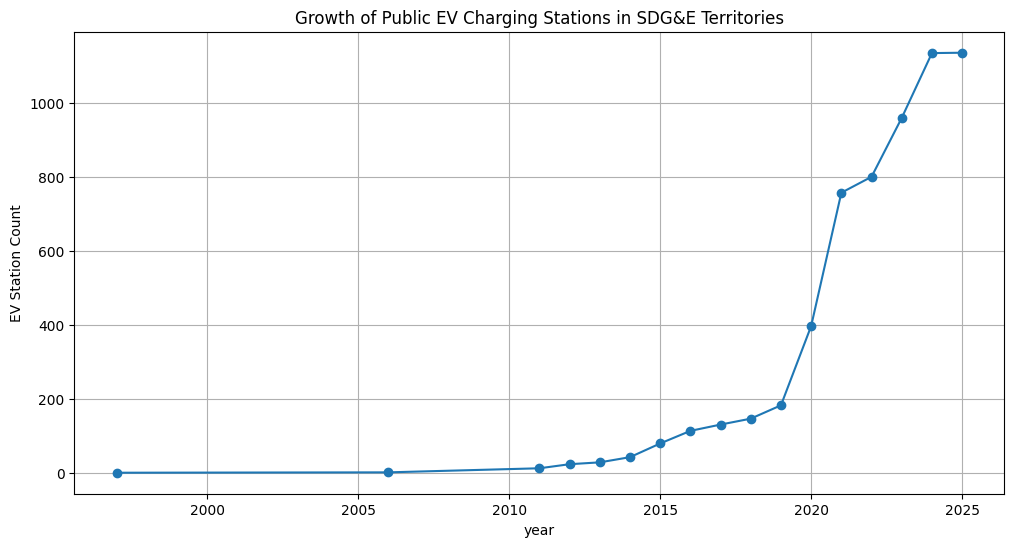

In [10]:
# time series EDA on how many public charging stations have opened throughout the past years

charging_station_data['open_date'] = pd.to_datetime(charging_station_data['open_date'])
public_ev_stations = charging_station_data[charging_station_data['access_code'] == 'public']

public_ev_stations['year'] = public_ev_stations['open_date'].dt.year
yearly_count = public_ev_stations.groupby('year').size().reset_index(name = 'num_stations')
yearly_count['cumulative_stations'] = yearly_count['num_stations'].cumsum()

plt.figure(figsize = (12, 6))
plt.plot(yearly_count['year'], yearly_count['cumulative_stations'], marker = 'o') 
plt.title('Growth of Public EV Charging Stations in SDG&E Territories')
plt.xlabel("year")
plt.ylabel('EV Station Count')
plt.grid()
plt.show()

In [11]:
# Create an interactive time series plot with Plotly
fig = px.line(
    yearly_count,
    x='year',
    y='cumulative_stations',
    title='Growth of Public Access Electric Charging Stations Over Time',
    labels={'year': 'Year', 'cumulative_stations': 'Number of Stations (Cumulative)'}
)

fig.add_annotation(
    x=2020, y=600,
    text="Sharp Increase between 2019-2020",
    showarrow=True,
    arrowhead=2,
    ax=0, ay=-40
)

fig.update_layout(width=1000, height=600)

fig.show()

In [12]:
public_ev_stations[public_ev_stations['station_name'] == 'UCSD Hopkins']

,station_name,city,state,zip,country,access_code,latitude,longitude,fuel_type_code,status_code,...,ev_connector_types,ev_dc_fast_num,ev_level1_evse_num,ev_level2_evse_num,ev_network,ev_network_web,ev_other_evse,ev_workplace_charging,ev_pricing,year
78868,UCSD Hopkins,La Jolla,CA,92037.0,US,public,32.883572,-117.23895,ELEC,E,...,['J1772'],NaN,NaN,20.0,POWERFLEX,https://www.powerflex.com,NaN,True,"Public charging: $0.50 per kWh M-F, $0.40 per ...",2022.0


In [13]:
# Step 1: Fill NA values with 0 for all relevant columns
public_ev_stations['ev_level1_evse_num'] = public_ev_stations['ev_level1_evse_num'].fillna(0)
public_ev_stations['ev_level2_evse_num'] = public_ev_stations['ev_level2_evse_num'].fillna(0)
public_ev_stations['ev_dc_fast_num'] = public_ev_stations['ev_dc_fast_num'].fillna(0)

# Step 2: Ensure data types are numeric
public_ev_stations['ev_level1_evse_num'] = public_ev_stations['ev_level1_evse_num'].astype(float)
public_ev_stations['ev_level2_evse_num'] = public_ev_stations['ev_level2_evse_num'].astype(float)
public_ev_stations['ev_dc_fast_num'] = public_ev_stations['ev_dc_fast_num'].astype(float)

# Step 3: Perform groupby and sum operation (without cumulative sum first)
yearly_sum = public_ev_stations.groupby('year')[['ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_num']].sum().cumsum().reset_index()


fig = px.line(
    yearly_sum, 
    x='year', 
    y=['ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_num'],
    title='Growth of EV Charging Stations by Type Over Time',
    labels={'value': 'Cumulative Number of Chargers', 'year': 'Year'},
    line_shape='linear'
)

fig.update_layout(
    yaxis_title='Number of Charging Ports',
    legend_title='Charging Type',
    margin={"r":0, "t":40, "l":40, "b":40}
)

fig.show()

/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_17062/2511367363.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_17062/2511367363.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_17062/2511367363.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

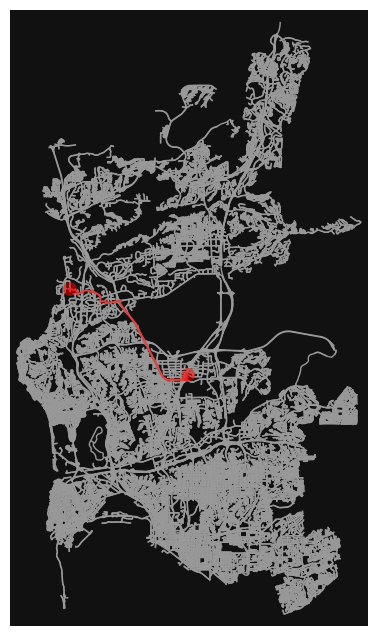

Driving distance from SDG&E to UCSD Hopkins station: 13.92 km / 8.65 miles.


In [14]:
# Coordinates for SDG&E's main office and UCSD Hopkins station
sdge_location = (32.824850, -117.142928)  # SDG&E main office coordinates
ucsd_hopkins_station = (32.883572, -117.23895)  # UCSD Hopkins station coordinates

# Download the graph for San Diego, specifically for driving routes
G = ox.graph_from_place('San Diego, California, USA', network_type='drive')

# Get the nearest nodes in the graph for SDG&E and UCSD Hopkins station
sdge_node = ox.distance.nearest_nodes(G, sdge_location[1], sdge_location[0])
ucsd_node = ox.distance.nearest_nodes(G, ucsd_hopkins_station[1], ucsd_hopkins_station[0])

# Calculate the shortest path between the two nodes
route_nodes = nx.shortest_path(G, sdge_node, ucsd_node, weight='length')

# Plot the route on the map
fig, ax = ox.plot_graph_route(G, route_nodes, route_color="r", route_linewidth=2, node_size=0)

# Convert the path to a GeoDataFrame to calculate the length
gdf = ox.routing.route_to_gdf(G, route_nodes)
pathlength_km = np.round((gdf["length"].sum() / 1000), 2)
pathlength_miles = np.round(pathlength_km / 1.609, 2)
print(f"Driving distance from SDG&E to UCSD Hopkins station: {pathlength_km:.2f} km / {pathlength_miles:.2f} miles.")
